In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

## SECTION 1: DATA LOADING AND BASIC VALIDATION

In [2]:
df_focal = pd.read_csv('../data/dataraw/data-1757985699237.csv')
df_competitors = pd.read_csv('../data/dataraw/data-1757985744315.csv')

print(f"Focal hotel data shape: {df_focal.shape}")
print(f"Competitor data shape: {df_competitors.shape}")

print("Focal hotel data types:", df_focal.dtypes)
print("Competitor data types:", df_competitors.dtypes)

df_focal['stay_date'] = pd.to_datetime(df_focal['stay_date'])
df_competitors['stay_date'] = pd.to_datetime(df_competitors['stay_date'])

print(f"Focal hotel unique hotel_ids: {df_focal['hotel_id'].nunique()}")
print(f"Focal hotel unique room types: {df_focal['room_type'].nunique()}")
print(f"Competitor unique hotel_ids: {df_competitors['hotel_id'].nunique()}")

Focal hotel data shape: (5110, 4)
Competitor data shape: (1820, 5)
Focal hotel data types: hotel_id     object
stay_date    object
room_type     int64
price         int64
dtype: object
Competitor data types: hotel_id               object
stay_date              object
price                 float64
can_check_in             bool
min_length_of_stay      int64
dtype: object
Focal hotel unique hotel_ids: 1
Focal hotel unique room types: 14
Competitor unique hotel_ids: 5


## SECTION 2: DATA QUALITY ASSESSMENT 

In [3]:
print("Focal hotel missing data:", df_focal.isnull().sum().sum())
print("Competitor missing data:", df_competitors.isnull().sum().sum())

if df_competitors['price'].isnull().sum() > 0:
    missing_by_hotel = df_competitors.groupby('hotel_id')['price'].agg(['count', lambda x: x.isnull().sum()])
    missing_by_hotel.columns = ['valid_prices', 'missing_prices']
    missing_by_hotel['missing_rate'] = missing_by_hotel['missing_prices'] / (missing_by_hotel['valid_prices'] + missing_by_hotel['missing_prices'])
    print("Missing price patterns:")
    print(missing_by_hotel)

focal_invalid = (df_focal['price'] <= 0).sum()
comp_invalid = (df_competitors['price'] <= 0).sum()
print(f"Invalid prices (<=0) - Focal: {focal_invalid}, Competitors: {comp_invalid}")

focal_q01, focal_q99 = df_focal['price'].quantile([0.01, 0.99])
comp_q01, comp_q99 = df_competitors['price'].quantile([0.01, 0.99])
print(f"Focal hotel price range: ${focal_q01:.2f} - ${focal_q99:.2f}")
print(f"Competitor price range: ${comp_q01:.2f} - ${comp_q99:.2f}")

if 'room_type' in df_focal.columns:
    room_type_analysis = df_focal.groupby('room_type')['price'].agg(['mean', 'std', 'count'])
    room_type_analysis = room_type_analysis.sort_values('mean')
    print("Room type pricing analysis:")
    print(room_type_analysis.round(2))

if 'can_check_in' in df_competitors.columns:
    availability_stats = df_competitors.groupby('hotel_id')['can_check_in'].mean()
    print("Availability rates by hotel:")
    print(availability_stats)

Focal hotel missing data: 0
Competitor missing data: 30
Missing price patterns:
                                                    valid_prices  \
hotel_id                                                           
booking-us-aqua-pacific-monarch-USD                          348   
booking-us-castle-kamaole-sands-USD                          364   
booking-us-courtyard-by-marriott-maui-kahului-a...           353   
booking-us-kohea-kai-resort-maui-USD                         362   
booking-us-ohana-waikiki-malia-USD                           363   

                                                    missing_prices  \
hotel_id                                                             
booking-us-aqua-pacific-monarch-USD                             16   
booking-us-castle-kamaole-sands-USD                              0   
booking-us-courtyard-by-marriott-maui-kahului-a...              11   
booking-us-kohea-kai-resort-maui-USD                             2   
booking-us-ohana-waikik

## SECTION 3: TEMPORAL ALIGNMENT AND OVERLAP ANALYSIS

In [4]:
date_overlap_start = max(df_focal['stay_date'].min(), df_competitors['stay_date'].min())
date_overlap_end = min(df_focal['stay_date'].max(), df_competitors['stay_date'].max())

if date_overlap_start <= date_overlap_end:
    overlap_days = (date_overlap_end - date_overlap_start).days + 1
    print(f"Temporal overlap: {overlap_days} days")
    
    focal_overlap = df_focal[(df_focal['stay_date'] >= date_overlap_start) & 
                             (df_focal['stay_date'] <= date_overlap_end)]
    comp_overlap = df_competitors[(df_competitors['stay_date'] >= date_overlap_start) & 
                                  (df_competitors['stay_date'] <= date_overlap_end)]
    
    print(f"Focal observations in overlap: {len(focal_overlap)}")
    print(f"Competitor observations in overlap: {len(comp_overlap)}")
else:
    print("No temporal overlap detected")
    focal_overlap = pd.DataFrame()
    comp_overlap = pd.DataFrame()

Temporal overlap: 364 days
Focal observations in overlap: 5096
Competitor observations in overlap: 1820


## SECTION 4: PRICE NORMALIZATION 

Focal hotel - Median: $319.00, MAD: $40.00
Competitors - Median: $298.90, MAD: $49.03
Normalized focal range: $164.07 - $1438.85
Competitor range: $179.00 - $904.12


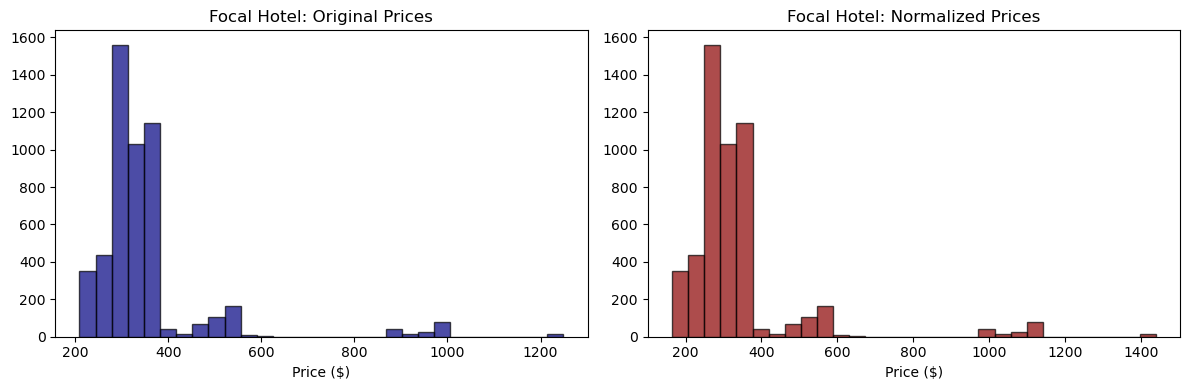

In [5]:
if not focal_overlap.empty and not comp_overlap.empty:
    
    focal_prices = focal_overlap['price'].dropna()
    comp_prices = comp_overlap['price'].dropna()
    
    focal_median = focal_prices.median()
    focal_mad = np.median(np.abs(focal_prices - focal_median))
    comp_median = comp_prices.median()
    comp_mad = np.median(np.abs(comp_prices - comp_median))
    
    print(f"Focal hotel - Median: ${focal_median:.2f}, MAD: ${focal_mad:.2f}")
    print(f"Competitors - Median: ${comp_median:.2f}, MAD: ${comp_mad:.2f}")
    
    focal_normalized = (focal_prices - focal_median) / focal_mad * comp_mad + comp_median
    
    print(f"Normalized focal range: ${focal_normalized.min():.2f} - ${focal_normalized.max():.2f}")
    print(f"Competitor range: ${comp_prices.min():.2f} - ${comp_prices.max():.2f}")
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    axes[0].hist(focal_prices, bins=30, alpha=0.7, color='navy', edgecolor='black')
    axes[0].set_title('Focal Hotel: Original Prices')
    axes[0].set_xlabel('Price ($)')
    
    axes[1].hist(focal_normalized, bins=30, alpha=0.7, color='darkred', edgecolor='black')
    axes[1].set_title('Focal Hotel: Normalized Prices')
    axes[1].set_xlabel('Price ($)')
    
    plt.tight_layout()
    plt.show()


## SECTION 5: COMPETITIVE RELATIONSHIP ANALYSIS

Common dates for analysis: 364
Price level correlation: 0.288
Price change correlation: 0.133
Normalized price correlation: 0.288
Strongest correlation at lag 1: 0.297


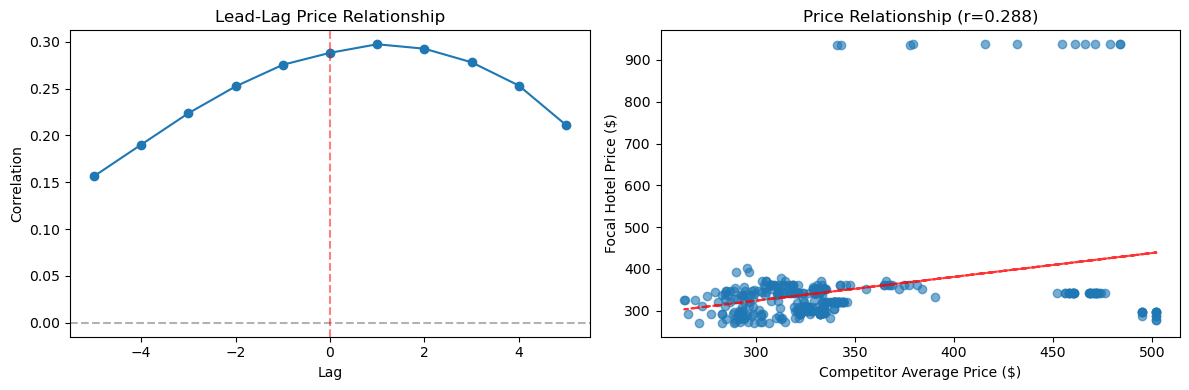

In [6]:
if not focal_overlap.empty and not comp_overlap.empty:
    
    focal_daily = focal_overlap.groupby('stay_date')['price'].mean()
    comp_daily = comp_overlap.groupby('stay_date')['price'].mean()
    common_dates = focal_daily.index.intersection(comp_daily.index)
    
    if len(common_dates) >= 10:
        focal_common = focal_daily.loc[common_dates]
        comp_common = comp_daily.loc[common_dates]
        
        price_correlation = focal_common.corr(comp_common)
        
        focal_changes = focal_common.diff().dropna()
        comp_changes = comp_common.diff().dropna()
        change_common_dates = focal_changes.index.intersection(comp_changes.index)
        
        if len(change_common_dates) >= 5:
            change_correlation = focal_changes.loc[change_common_dates].corr(comp_changes.loc[change_common_dates])
        else:
            change_correlation = np.nan
        
        print(f"Common dates for analysis: {len(common_dates)}")
        print(f"Price level correlation: {price_correlation:.3f}")
        print(f"Price change correlation: {change_correlation:.3f}")
        
        if 'focal_normalized' in locals():
            focal_norm_daily = focal_normalized.groupby(focal_overlap.loc[focal_prices.index, 'stay_date']).mean()
            focal_norm_common = focal_norm_daily.loc[focal_norm_daily.index.intersection(comp_common.index)]
            comp_norm_common = comp_common.loc[focal_norm_common.index]
            
            if len(focal_norm_common) >= 10:
                normalized_correlation = focal_norm_common.corr(comp_norm_common)
                print(f"Normalized price correlation: {normalized_correlation:.3f}")
        
        lags = range(-5, 6)
        lead_lag_corr = []
        
        for lag in lags:
            if lag == 0:
                corr = focal_common.corr(comp_common)
            elif lag > 0:
                focal_shifted = focal_common.shift(lag)
                common_idx = focal_shifted.dropna().index.intersection(comp_common.index)
                if len(common_idx) >= 5:
                    corr = focal_shifted.loc[common_idx].corr(comp_common.loc[common_idx])
                else:
                    corr = np.nan
            else:
                comp_shifted = comp_common.shift(-lag)
                common_idx = comp_shifted.dropna().index.intersection(focal_common.index)
                if len(common_idx) >= 5:
                    corr = focal_common.loc[common_idx].corr(comp_shifted.loc[common_idx])
                else:
                    corr = np.nan
            lead_lag_corr.append(corr)
        
        valid_corrs = [(lag, corr) for lag, corr in zip(lags, lead_lag_corr) if not np.isnan(corr)]
        if valid_corrs:
            max_corr_lag, max_corr = max(valid_corrs, key=lambda x: abs(x[1]))
            print(f"Strongest correlation at lag {max_corr_lag}: {max_corr:.3f}")
        
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.plot(lags, lead_lag_corr, marker='o')
        plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
        plt.axvline(x=0, color='r', linestyle='--', alpha=0.5)
        plt.xlabel('Lag')
        plt.ylabel('Correlation')
        plt.title('Lead-Lag Price Relationship')
        
        plt.subplot(1, 2, 2)
        plt.scatter(comp_common, focal_common, alpha=0.6)
        plt.xlabel('Competitor Average Price ($)')
        plt.ylabel('Focal Hotel Price ($)')
        plt.title(f'Price Relationship (r={price_correlation:.3f})')
        
        z = np.polyfit(comp_common, focal_common, 1)
        p = np.poly1d(z)
        plt.plot(comp_common, p(comp_common), "r--", alpha=0.8)
        
        plt.tight_layout()
        plt.show()

## SECTION 6: INSTRUMENT VALIDATION FOR 2SRI

In [7]:
print("Available instruments:")
print("  - Day of week effects: Yes")
print("  - Monthly/seasonal effects: Yes")

if 'can_check_in' in df_competitors.columns and len(common_dates) >= 10:
    availability_by_date = comp_overlap.groupby('stay_date')['can_check_in'].mean()
    avail_focal_corr = availability_by_date.loc[common_dates].corr(focal_common)
    avail_comp_corr = availability_by_date.loc[common_dates].corr(comp_common)
    
    print(f"  - Availability-Focal correlation: {avail_focal_corr:.3f}")
    print(f"  - Availability-Competitor correlation: {avail_comp_corr:.3f}")

Available instruments:
  - Day of week effects: Yes
  - Monthly/seasonal effects: Yes
  - Availability-Focal correlation: 0.104
  - Availability-Competitor correlation: -0.440


## SECTION 7: ROOM TYPE SEGMENTATION ANALYSIS

In [8]:
if 'room_type' in df_focal.columns and not focal_overlap.empty:
    
    room_types = sorted(df_focal['room_type'].unique())
    room_correlations = {}
    
    for room_type in room_types:
        room_data = focal_overlap[focal_overlap['room_type'] == room_type]
        if len(room_data) >= 30:
            room_daily = room_data.groupby('stay_date')['price'].mean()
            room_common_dates = room_daily.index.intersection(comp_common.index)
            
            if len(room_common_dates) >= 10:
                room_corr = room_daily.loc[room_common_dates].corr(comp_common.loc[room_common_dates])
                room_correlations[room_type] = room_corr
    
    if room_correlations:
        print("Room type correlations with competitor pricing:")
        for room_type, corr in sorted(room_correlations.items(), key=lambda x: abs(x[1]), reverse=True):
            print(f"  Room {room_type}: {corr:.3f}")

Room type correlations with competitor pricing:
  Room 10576: 0.529
  Room 10572: 0.281
  Room 10573: 0.281
  Room 10574: 0.281
  Room 10575: 0.281
  Room 10578: 0.280
  Room 10579: 0.280
  Room 14509: 0.279
  Room 14492: 0.279
  Room 14491: 0.278
  Room 14493: 0.277
  Room 10580: 0.276
  Room 10577: 0.275
  Room 10581: 0.274


## SECTION 8: 2SRI IMPLEMENTATION READINESS ASSESSMENT

In [9]:
assessment = {}
assessment['sufficient_overlap'] = len(common_dates) >= 100 if 'common_dates' in locals() else False
assessment['clean_price_data'] = (focal_invalid + comp_invalid) == 0
assessment['missing_data_manageable'] = df_competitors['price'].isnull().sum() / len(df_competitors) < 0.05
assessment['price_variation_adequate'] = focal_prices.std() > 0 and comp_prices.std() > 0 if not focal_overlap.empty else False
assessment['meaningful_correlation'] = abs(price_correlation) > 0.2 if 'price_correlation' in locals() else False
assessment['multiple_competitors'] = df_competitors['hotel_id'].nunique() >= 3
assessment['instruments_available'] = True

readiness_score = sum(assessment.values()) / len(assessment)

print("2SRI Implementation Readiness Assessment:")
for check, result in assessment.items():
    status = "PASS" if result else "NEEDS ATTENTION"
    print(f"  {check}: {status}")

print(f"Overall readiness score: {readiness_score:.1%}")

if readiness_score >= 0.7:
    print("Status: READY FOR 2SRI IMPLEMENTATION")
elif readiness_score >= 0.5:
    print("Status: CAUTIOUS IMPLEMENTATION ADVISED")
else:
    print("Status: SIGNIFICANT PREPARATION NEEDED")

2SRI Implementation Readiness Assessment:
  sufficient_overlap: PASS
  clean_price_data: PASS
  missing_data_manageable: PASS
  price_variation_adequate: PASS
  meaningful_correlation: PASS
  multiple_competitors: PASS
  instruments_available: PASS
Overall readiness score: 100.0%
Status: READY FOR 2SRI IMPLEMENTATION
